#Table of Contents
* [Imports](#Imports)
* [Notes](#Notes)
* [Reflection/Refraction utility functions](#Reflection/Refraction-utility-functions)
* [Class - rayThroughPlanarInterfaces](#Class---rayThroughPlanarInterfaces)
* [Test rayThroughPlanarInterfaces](#Test-rayThroughPlanarInterfaces)
	* [Make rays at every 10 degrees going through water/SiO2/Si](#Make-rays-at-every-10-degrees-going-through-water/SiO2/Si)
	* [Plot rays going through materials & interfaces](#Plot-rays-going-through-materials-&-interfaces)
* [Color rays according to how much power they have & put a colorbar next to graph](#Color-rays-according-to-how-much-power-they-have-&-put-a-colorbar-next-to-graph)
* [Color each segment of a line according to how much power is in it](#Color-each-segment-of-a-line-according-to-how-much-power-is-in-it)
	* [Helper functions to make a LineCollection](#Helper-functions-to-make-a-LineCollection)
	* [Final plot with rays at 5 degree increments](#Final-plot-with-rays-at-5-degree-increments)
* [Next](#Next)


In [4]:
%%javascript
IPython.load_extensions('calico-document-tools');

<IPython.core.display.Javascript object>

#Imports 

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
from IPython.display import Image
from __future__ import division
from __future__ import print_function

degtorad = np.pi/180.

#Notes

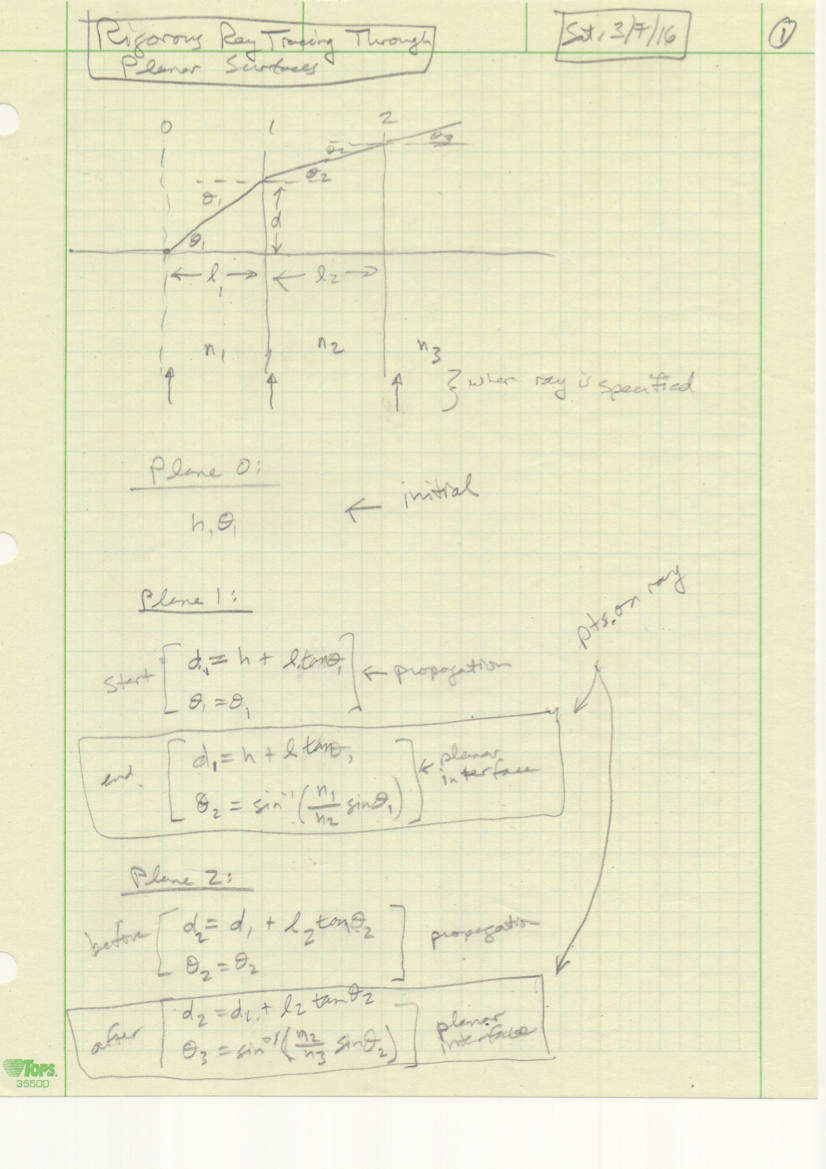

In [2]:
Image(filename='150308 Notes pg1.png')

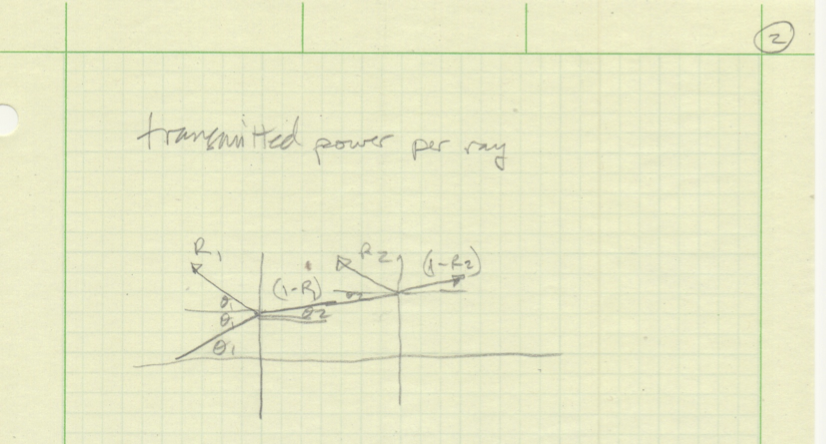

In [3]:
Image(filename='150308 Notes pg2.png')

#Reflection/Refraction utility functions 

In [58]:
def theta2_from_Snells_law(angle1, n1, n2):
    return np.arcsin(np.sin(angle1) * n1 / n2)

def reflectance_TE(angle1, n1, n2):
    angle2 = theta2_from_Snells_law(angle1, n1, n2)
    temp = n1*np.cos(angle1) - n2*np.cos(angle2)
    temp = temp / (n1*np.cos(angle1) + n2*np.cos(angle2))
    return temp**2

def transmittance_TE(angle1, n1, n2):
    return 1.0 - reflectance_TE(angle1, n1, n2)

def reflectance_TM(angle1, n1, n2):
    angle2 = theta2_from_Snells_law(angle1, n1, n2)
    temp = n1*np.cos(angle2) - n2*np.cos(angle1)
    temp = temp / (n1*np.cos(angle2) + n2*np.cos(angle1))
    return temp**2

def transmittance_TM(angle1, n1, n2):
    return 1.0 - reflectance_TM(angle1, n1, n2)

def reflectance_Unpol(angle1, n1, n2):
    rTE = reflectance_TE(angle1, n1, n2)
    rTM = reflectance_TM(angle1, n1, n2)
    return 0.5 * (rTE + rTM)

def transmittance_Unpol(angle1, n1, n2):
    return 1.0 - reflectance_Unpol(angle1, n1, n2)

n1 = 1.46
n2 = 3.6
for angle in range(0,90,5):
    print(angle, reflectance_TE(angle*degtorad, n1, n2), transmittance_TE(angle*degtorad, n1, n2))
print( ( (n1-n2) / (n1+n2))**2 )

0 0.178865472043 0.821134527957
5 0.179973379145 0.820026620855
10 0.183334047056 0.816665952944
15 0.189059888997 0.810940111003
20 0.19734353503 0.80265646497
25 0.208465839665 0.791534160335
30 0.222807247586 0.777192752414
35 0.240862582488 0.759137417512
40 0.263259199158 0.736740800842
45 0.29077818309 0.70922181691
50 0.324377845946 0.675622154054
55 0.365218099039 0.634781900961
60 0.414683353175 0.585316646825
65 0.474400389054 0.525599610946
70 0.54624623136 0.45375376864
75 0.632339604707 0.367660395293
80 0.735008340143 0.264991659857
85 0.856724550981 0.143275449019
0.178865472043


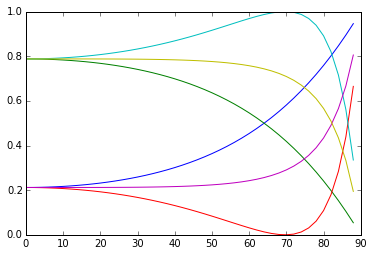

In [59]:
n1 = 1.33
n2 = 3.6
angles = []
R_TE = []
T_TE = []
R_TM = []
T_TM = []
R_Unpol = []
T_Unpol = []
for angle in range(0,90,2):
    angles = np.append(angles, angle)
    R_TE = np.append(R_TE, reflectance_TE(angle*degtorad, n1, n2))
    T_TE = np.append(T_TE, transmittance_TE(angle*degtorad, n1, n2))
    R_TM = np.append(R_TM, reflectance_TM(angle*degtorad, n1, n2))
    T_TM = np.append(T_TM, transmittance_TM(angle*degtorad, n1, n2))
    R_Unpol = np.append(R_Unpol, reflectance_Unpol(angle*degtorad, n1, n2))
    T_Unpol = np.append(T_Unpol, transmittance_Unpol(angle*degtorad, n1, n2))
fig, ax = plt.subplots(1,1)
ax.plot(angles, R_TE)
ax.plot(angles, T_TE)
ax.plot(angles, R_TM)
ax.plot(angles, T_TM)
ax.plot(angles, R_Unpol)
ax.plot(angles, T_Unpol)

#Class - rayThroughPlanarInterfaces 

In [9]:
class rayThroughPlanarInterfaces():
    
    def __init__(self, ray_dist_from_axis=0.0, angle_rad=0.0, refr_index=1.0, start_location_on_axis=0.0):
        self.h = np.array([ray_dist_from_axis])
        self.ang_rad = np.array([angle_rad])
        self.refr_index = np.array([refr_index])
        self.location_on_axis = np.array([start_location_on_axis])
        self.normpower_in_rayTE = np.array([1.0])
        self.normpower_in_rayTM = np.array([1.0])
        self.normpower_in_rayUnpol = np.array([1.0])
        
    def propagate_to_and_thru_new_surface(self,l,new_refr_index):
        self.normpower_in_rayTE = np.append(self.normpower_in_rayTE, 
                                          self.normpower_in_rayTE[-1] * 
                                          transmittance_TE(self.ang_rad[-1],self.refr_index[-1],new_refr_index))
        self.normpower_in_rayTM = np.append(self.normpower_in_rayTM, 
                                          self.normpower_in_rayTM[-1] * 
                                          transmittance_TM(self.ang_rad[-1],self.refr_index[-1],new_refr_index))
        self.normpower_in_rayUnpol = 0.5 * (self.normpower_in_rayTE[-1] + self.normpower_in_rayTM[-1])
        self.location_on_axis = np.append(self.location_on_axis, self.location_on_axis[-1] + l)
        delta_h = l*np.tan(self.ang_rad[-1])
        self.h = np.append(self.h, self.h[-1] + delta_h)
        new_angle = np.arcsin(np.sin(self.ang_rad[-1])*self.refr_index[-1]/new_refr_index)
        self.ang_rad = np.append(self.ang_rad, new_angle)
        self.refr_index = np.append(self.refr_index, new_refr_index)
        
    def print_values(self):
        print('location_on_axis', 'h', 'ang_rad', 'refr_index', 'normalized power')
        print(self.location_on_axis, self.h, self.ang_rad, self.refr_index)
        print(self.normpower_in_rayTE, self.normpower_in_rayTM, self.normpower_in_rayUnpol)
        
test = rayThroughPlanarInterfaces(ray_dist_from_axis=0.0, 
                                  angle_rad=80.0*degtorad, 
                                  refr_index=1.33, 
                                  start_location_on_axis=0.0)
test.print_values()
test.propagate_to_and_thru_new_surface(1, 1.46)
test.print_values()
test.propagate_to_and_thru_new_surface(1, 3.6)
test.print_values()
test.propagate_to_and_thru_new_surface(1, 3.6)
test.print_values()

location_on_axis h ang_rad refr_index normalized power
[ 0.] [ 0.] [ 1.3962634] [ 1.33]
[ 1.] [ 1.] [ 1.]
location_on_axis h ang_rad refr_index normalized power
[ 0.  1.] [ 0.          5.67128182] [ 1.3962634   1.11320538] [ 1.33  1.46]
[ 1.          0.77656438] [ 1.          0.84226504] 0.80941470753
location_on_axis h ang_rad refr_index normalized power
[ 0.  1.  2.] [ 0.          5.67128182  7.70193685] [ 1.3962634   1.11320538  0.37237829] [ 1.33  1.46  3.6 ]
[ 1.          0.77656438  0.42026779] [ 1.          0.84226504  0.83712422] 0.628696005593
location_on_axis h ang_rad refr_index normalized power
[ 0.  1.  2.  3.] [ 0.          5.67128182  7.70193685  8.09253861] [ 1.3962634   1.11320538  0.37237829  0.37237829] [ 1.33  1.46  3.6   3.6 ]
[ 1.          0.77656438  0.42026779  0.42026779] [ 1.          0.84226504  0.83712422  0.83712422] 0.628696005593


In [10]:
angle_deg = 80.0
angle_rad = angle_deg * degtorad
print(angle_deg, angle_rad, degtorad)
print(1.0 * np.tan(angle_rad))

80.0 1.3962634016 0.0174532925199
5.67128181962


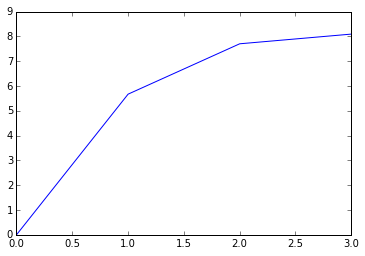

In [11]:
fig, ax = plt.subplots(1,1)
ax.plot(test.location_on_axis, test.h)

#Test rayThroughPlanarInterfaces

##Make rays at every 10 degrees going through water/SiO2/Si 

In [12]:
thicknesses = np.array([1.0, 1.0, 4.0])
refractive_indices = np.array([1.46, 3.6, 3.6])
initial_refr_index = 1.33
start_location_on_axis = 0.0
array_of_rays = []
for i, angle in enumerate(range(-80,90,10)):
    array_of_rays.append(rayThroughPlanarInterfaces(ray_dist_from_axis = 0.0, 
                                                    angle_rad = angle*degtorad, 
                                                    refr_index = initial_refr_index, 
                                                    start_location_on_axis = start_location_on_axis))
    for l,n in zip(thicknesses, refractive_indices):
        array_of_rays[i].propagate_to_and_thru_new_surface(l, n)

##Plot rays going through materials & interfaces

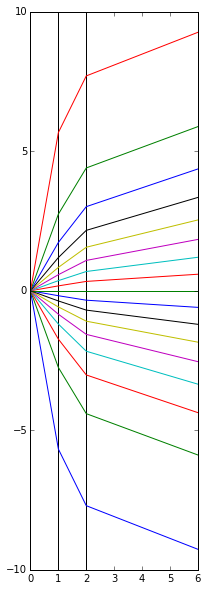

In [13]:
fig, ax = plt.subplots(1,1,figsize = (10,10))
ax.set_aspect('equal')
for ray in array_of_rays:
    ax.plot(ray.location_on_axis, ray.h)
for x in array_of_rays[0].location_on_axis:
    ax.vlines(x,-10,10)

cmap=plt.get_cmap('Blues')

#Color rays according to how much power they have & put a colorbar next to graph 

See http://matplotlib.org/examples/color/colormaps_reference.html for a good colormap reference

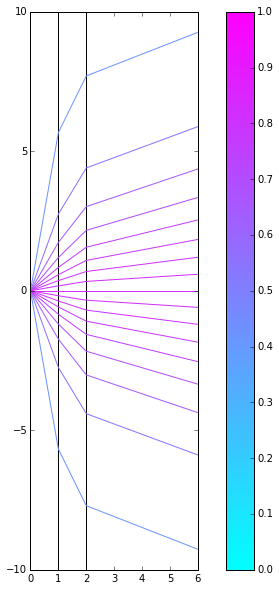

In [14]:
fig, ax = plt.subplots(1,1,figsize = (10,10))
ax.set_aspect('equal')
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap._A = [] #see http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plotsa
plt.colorbar(scalarMap)

for ray in array_of_rays:
    colorVal = scalarMap.to_rgba(ray.normpower_in_rayTE[-1])
    ax.plot(ray.location_on_axis, ray.h, color=colorVal)
for x in array_of_rays[0].location_on_axis:
    ax.vlines(x,-10,10)


In [7]:
thicknesses = np.array([1.0, 2.0, 1.0])
refractive_indices = np.array([1.33, 1.46, 3.6])

for l, n in zip(thicknesses, refractive_indices):
    print(l, n)

1.0 1.33
2.0 1.46
1.0 3.6


In [14]:
for i, angle in enumerate(range(-80,80,10)):
    print(i, angle)

0 -80
1 -70
2 -60
3 -50
4 -40
5 -30
6 -20
7 -10
8 0
9 10
10 20
11 30
12 40
13 50
14 60
15 70


# Color each segment of a line according to how much power is in it

##Helper functions to make a LineCollection 

From here: http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb

grab the utility functions to use LineCollections to color each line segment according to how much power is in that segment

In [31]:
# Topics: line, color, LineCollection, cmap, colorline, codex
'''
Defines a function colorline that draws a (multi-)colored 2D line with coordinates x and y.
The color is taken from optional data in z, and creates a LineCollection.

z can be:
- empty, in which case a default coloring will be used based on the position along the input arrays
- a single number, for a uniform color [this can also be accomplished with the usual plt.plot]
- an array of the length of at least the same length as x, to color according to this data
- an array of a smaller length, in which case the colors are repeated along the curve

The function colorline returns the LineCollection created, which can be modified afterwards.

See also: plt.streamplot
'''

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


# Data manipulation:

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(ax, x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    #ax = plt.gca()
    ax.add_collection(lc)
    
    return lc
        
    
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 

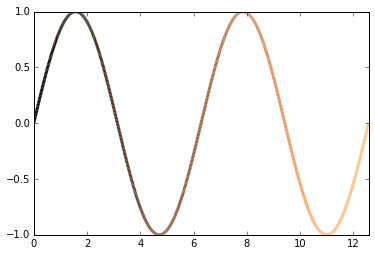

In [32]:
# Sine wave colored by time

x = np.linspace(0, 4.*np.pi, 1000)
y = np.sin(x)

fig, axes = plt.subplots()

colorline(axes, x, y)

plt.xlim(x.min(), x.max())
plt.ylim(-1.0, 1.0)
plt.show()

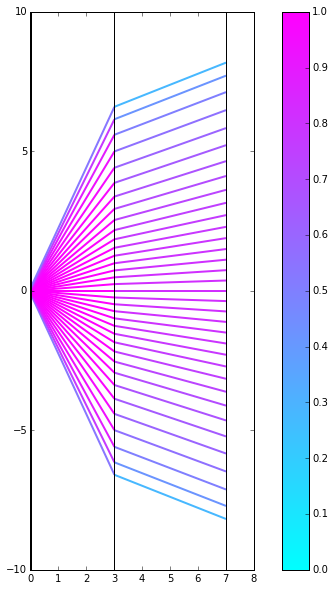

In [33]:
fig, ax = plt.subplots(1,1,figsize = (10,10))
ax.set_aspect('equal')
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap._A = [] #see http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plotsa
plt.colorbar(scalarMap)

for ray in array_of_rays:
    colorline(ax, x=ray.location_on_axis, y=ray.h, z=ray.normpower_in_rayTE, cmap=cmap, norm=cNorm, linewidth=2.0)
for x in array_of_rays[0].location_on_axis:
    ax.vlines(x,-10,10)


##Final plot with rays at 5 degree increments 

In [17]:
thicknesses = np.array([0.01, 3.0, 4.0])
refractive_indices = np.array([1.46, 3.6, 3.6])
initial_refr_index = 1.33
start_location_on_axis = 0.0
array_of_rays = []
for i, angle in enumerate(range(-85,90,5)):
    array_of_rays.append(rayThroughPlanarInterfaces(ray_dist_from_axis = 0.0, 
                                                    angle_rad = angle*degtorad, 
                                                    refr_index = initial_refr_index, 
                                                    start_location_on_axis = start_location_on_axis))
    for l,n in zip(thicknesses, refractive_indices):
        array_of_rays[i].propagate_to_and_thru_new_surface(l, n)

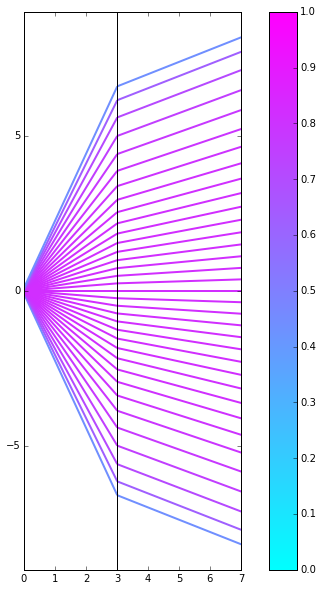

In [34]:
ylimit = 9
fig, ax = plt.subplots(1,1,figsize = (10,10))
ax.set_aspect('equal')
ax.set_ylim(-ylimit,ylimit)
ax.set_xlim(0, ray.location_on_axis[-1])
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap._A = [] #see http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plotsa
plt.colorbar(scalarMap)

for ray in array_of_rays:
    colorline(ax, x=ray.location_on_axis, y=ray.h, z=ray.normpower_in_rayUnpol, cmap=cmap, norm=cNorm, linewidth=2.0)
for x in array_of_rays[0].location_on_axis:
    ax.vlines(x,-ylimit,ylimit)

<matplotlib.colorbar.Colorbar instance at 0x1123afd40>

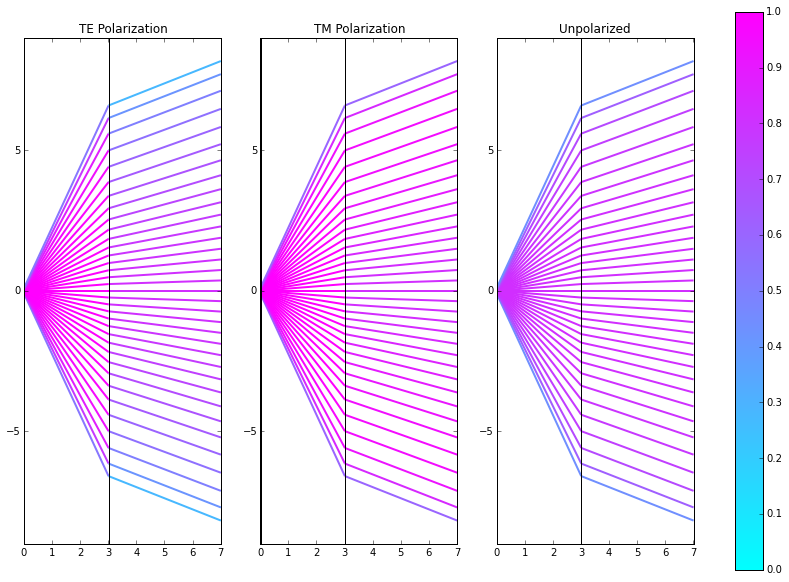

In [57]:
import matplotlib as mpl

ylimit = 9
fig, axes = plt.subplots(1,3,figsize = (15,10))
for ax in axes:
    ax.set_aspect('equal')
    ax.set_ylim(-ylimit,ylimit)
    ax.set_xlim(0, ray.location_on_axis[-1])
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap._A = [] #see http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plotsa

# Plot rays
for ray in array_of_rays:
    colorline(axes[0], x=ray.location_on_axis, y=ray.h, z=ray.normpower_in_rayTE, cmap=cmap, norm=cNorm, linewidth=2.0)
    colorline(axes[1], x=ray.location_on_axis, y=ray.h, z=ray.normpower_in_rayTM, cmap=cmap, norm=cNorm, linewidth=2.0)
    colorline(axes[2], x=ray.location_on_axis, y=ray.h, z=ray.normpower_in_rayUnpol, cmap=cmap, norm=cNorm, linewidth=2.0)

# Make vertical lines to indicate position of planar interfaces
for ax in axes:
    for x in array_of_rays[0].location_on_axis:
        ax.vlines(x,-ylimit,ylimit)
        ax.vlines(x,-ylimit,ylimit)
        
# Set plot titles
axes[0].set_title('TE Polarization')
axes[1].set_title('TM Polarization')
axes[2].set_title('Unpolarized')

# Plot the colormap, see 3rd answer at http://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar
fig.colorbar(scalarMap, ax=axes.ravel().tolist()) 

# Next 

- DONE 3/11/15 - Do same plot but for TM polarization & unpolarized light (different power for each ray segment)
- Integrate power that makes it into silicon surface
  - Need to average TE and TM polarizations
- Calculate what fraction of this power generates collectable charge carriers
- **Compare to calculation for using a lens to collect power and direct it to silicon sensor**